In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'

In [3]:
# Summary
# File Name: chb01_03.edf
# File Start Time: 13:43:04
# File End Time: 14:43:04
# Number of Seizures in File: 1
# Seizure Start Time: 2996 seconds
# Seizure End Time: 3036 seconds
raw = mne.io.read_raw_edf(input_fname=os.path.join(root, os.listdir(root)[3]), preload=False, verbose='Error')
ch_names = raw.info['ch_names'] # array of channel names

In [4]:
# sample a normal (interictal) clip of length similar to seizure
interictal_start_time = 720 # in seconds
interictal_end_time = interictal_start_time + 40
EEG_interictal, times_interictal = raw.copy() \
                            .crop(tmin=interictal_start_time, tmax=interictal_end_time) \
                            .get_data(picks=['eeg'], units='uV', return_times=True)
print(f'Start: {interictal_start_time}s, End: {interictal_end_time}s')
print(f'Duration: {np.max(times_interictal) - np.min(times_interictal)}s')
print(f'Dimensions: {EEG_interictal.shape}')

Start: 720s, End: 760s
Duration: 40.0s
Dimensions: (23, 10241)


$AR(1)$ model of first channel.

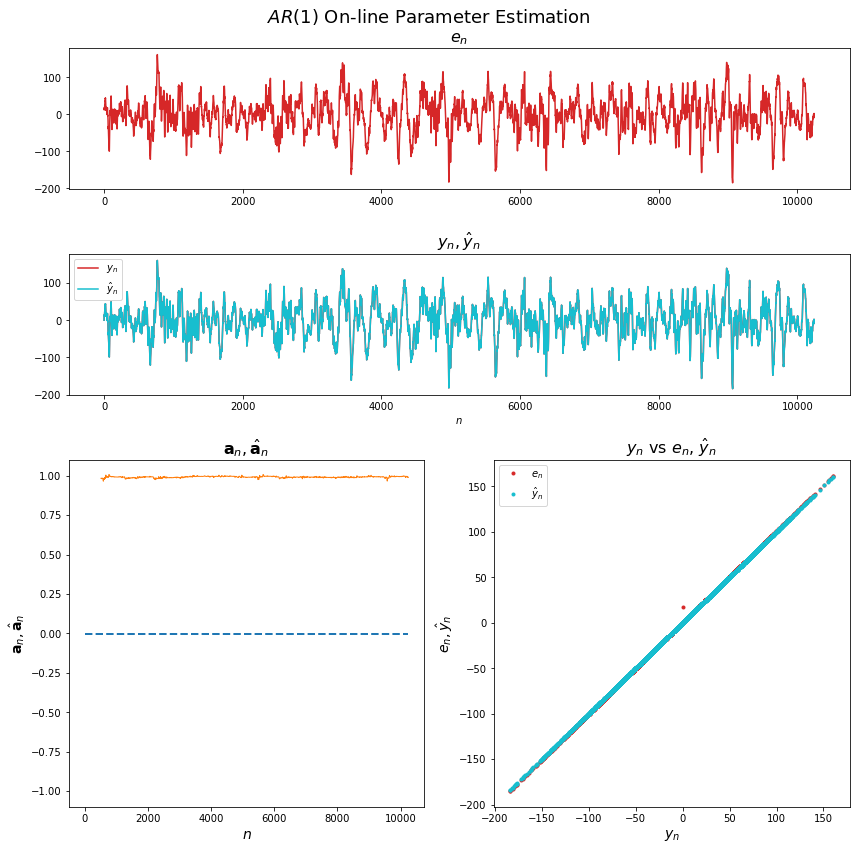

In [12]:
np.random.seed(42)
e = EEG_interictal[0,:]
N = len(e)
L = 512
p = 1
a = 1.8 * np.random.randn(p) - 0.9
n = np.arange(0, N)

y = np.zeros(N)
for i in range(p, N):
    y[i] = e[i]
    y[i] = y[i] + a.squeeze() * y[i-p]

arn_list = []
arhat_list = []
for _n in range(L+p, N):                     # On-line estimation of AR parameters by moving window
    arn_list.append(_n)
    
    window_start = _n-L-p+1
    window_end = _n
    y_window = y[window_start:window_end]
    N_window = len(y_window)
    ymat = np.zeros((N_window-p, p))
    yb = np.zeros((N_window-p, p))
    ymat[:,0] = y_window[0:-1]
    yb = y_window[p:]
    arhat_window = np.linalg.pinv(ymat)@yb
    arhat_list.append(arhat_window)
    
    if (arn_list[-1] == N-1):
        arn_list.append(N-1)
        
        window_start = N-L+p
        window_end = N
        y_window = y[window_start:window_end]
        N_window = len(y_window)
        ymat = np.zeros((N_window-p, p))
        yb = np.zeros((N_window-p, p))
        ymat[:,0] = y_window[0:-1]
        yb = y_window[p:]
        arhat_window = np.linalg.pinv(ymat)@yb
        arhat_list.append(arhat_window)
arn = np.array(arn_list)
arhat = np.array(arhat_list)

y_hat = np.zeros(N)
for i in range(p, N):
    y_hat[i] = e[i]
    y_hat[i] = y_hat[i] + a.squeeze() * y_hat[i-1]

plt.figure(figsize=(12,12))                  # Visualisations

plt.subplot2grid((4,2), (0, 0), rowspan=1, colspan=2)
plt.plot(n, e, color='tab:red', label="$e_n$")
plt.title("$e_n$", fontsize=16)

plt.subplot2grid((4,2), (1, 0), rowspan=1, colspan=2)
plt.plot(0,0)                                  
plt.plot(n, y, ls='solid', color='tab:red', label=r'$y_n$')
plt.plot(n, y_hat, ls='solid', color='tab:cyan', label=r'$\hat{y}_n$')
plt.xlabel(r'$n$')
plt.legend(loc='best')
plt.title(r'$y_n, \hat{y}_n$', fontsize=16)

plt.subplot2grid((4,2), (2, 0), rowspan=2, colspan=1)
_p = plt.plot(arn, arhat, color='tab:orange', lw=1)
plt.plot([0, n[-1]], [a, a], '--', lw=2, color='tab:blue')
plt.ylim(-1.1, 1.1)
plt.xlabel("$n$", fontsize=14)
plt.ylabel("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=14)
plt.title("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=16)

plt.subplot2grid((4,2), (2,1), rowspan=2, colspan=1)
plt.plot(y, e, '.', color='tab:red', label=r'$e_n$')
plt.plot(y, y_hat, '.', color='tab:cyan', label=r'$\hat{y}_n$')
plt.legend(loc='best')
plt.xlabel(r'$y_n$', fontsize=14)
plt.ylabel(r'$e_n, \hat{y}_n$', fontsize=14)
plt.title(r'$y_n$ vs $e_n$, $\hat{y}_n$', fontsize=16)

plt.suptitle(r'$AR(1)$ On-line Parameter Estimation', fontsize=18)
plt.tight_layout()
plt.show()

In [15]:
arhat

array([[0.98331843],
       [0.98335982],
       [0.98334944],
       ...,
       [0.98941168],
       [0.98901861],
       [0.98906693]])